<a href="https://colab.research.google.com/github/uptrain-ai/uptrain/blob/main/examples/integrations/observation_tools/promptfoo/promptfoo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h1 align="center">
  <a href="https://uptrain.ai">
    <img width="300" src="https://user-images.githubusercontent.com/108270398/214240695-4f958b76-c993-4ddd-8de6-8668f4d0da84.png" alt="UpTrain">
  </a>
</h1>

<div style="text-align: center;">

#  LLM Evaluations with Promptfoo and UpTrain

[Promptfoo](https://www.promptfoo.dev/) is an LLM observability tool that helps observe your LLM experiments. Using Promptfoo you can compare prompts and model outputs side-by-side, or integrate the library into your existing test/CI workflow.

This notebook demonstrates how to observe your LLM experiments for latency, tokens and cost using Promptfoo.
Further using UpTrain we can evaluate over metrics such as:
1. [Context Relevance](https://docs.uptrain.ai/predefined-evaluations/context-awareness/context-relevance): Evaluates how relevant the retrieved context is to the question specified.

2. [Factual Accuracy](https://docs.uptrain.ai/predefined-evaluations/context-awareness/factual-accuracy): Evaluates whether the response generated is factually correct and grounded by the provided context.

3. [Response Completeness](https://docs.uptrain.ai/predefined-evaluations/response-quality/response-completeness): Evaluates whether the response has answered all the aspects of the question specified

You can look at the complete list of UpTrain's supported metrics [here](https://docs.uptrain.ai/predefined-evaluations/overview)

### Overview

In this notebook we will be testing out a set of 2 prompts.

These prompts answers user's query based on a retrieved context.

We will be using these Uptrain's [Factual Accuracy](https://docs.uptrain.ai/predefined-evaluations/context-awareness/factual-accuracy) to evaluate the outputs generated using these prompts

### Step 1: Install Dependencies

In [1]:
!npx --yes promptfoo init

(node:59541) [DEP0040] DeprecationWarning: The `punycode` module is deprecated. Please use a userland alternative instead.
(Use `node --trace-deprecation ...` to show where the warning was created)
✅ Wrote promptfooconfig.yaml. Run `promptfoo eval` to get started!


In [2]:
!pip install loguru uptrain==0.5.0 -q

### Step 2: Create your prompts

In [3]:
%%writefile prompts.txt
Answer the following user query using the retrieved context:
{{question}}
The retrieved document has the following text:
{{context}}
Give the worst possible answer, which is factually incorrect and irrelevant to the retrieved document.
Answer:
---
Answer the following user query using the retrieved context:
{{question}}
The retrieved document has the following text:
{{context}}
Ensure that the response is very elaborative to the given question.
Answer:

Overwriting prompts.txt


### Step 3: Define Inputs to Run Evaluations using UpTrain & Promptfoo

In [4]:
%%writefile promptfooconfig.yaml
prompts: [prompts.txt]
providers: [openai:chat:gpt-3.5-turbo-0613, openai:chat:gpt-4]
tests:
  - description: 'UpTrain Test'
    vars:
      question: Which is the most popular global sport? 
      context: Football is undoubtedly on of the most popular sport with major events like the FIFA World Cup and sports personalities like Ronaldo and Messi, drawing a followership of more than 4 billion people. 
    assert:
      - type: python
        value: |
            from loguru import logger
            import uptrain.framework
            import json
            import os
            data = [{       # Update your Data
              'question': 'Which is the most popular global sport?',
              'context': 'Football is undoubtedly on of the most popular sport with major events like the FIFA World Cup and sports personalities like Ronaldo and Messi, drawing a followership of more than 4 billion people.',
              'response': output
            }]
            logger.remove()
            eval_llm = uptrain.framework.EvalLLM(openai_api_key = os.environ["OPENAI_API_KEY"]) # UpTrain uses your OpenAI Key to run evaluations
            results = eval_llm.evaluate(
              data=data,
              checks=[uptrain.framework.Evals.FACTUAL_ACCURACY]
            )
            if results[0]['score_factual_accuracy']>0.5:
              print(json.dumps({
                  'pass': True,
                  'score': results[0]['score_factual_accuracy'],
                  'reason': results[0]['explanation_factual_accuracy'],
                }))
            else:
              print(json.dumps({
                  'pass': False,
                  'score': results[0]['score_factual_accuracy'],
                  'reason': results[0]['explanation_factual_accuracy'],
                }))

Overwriting promptfooconfig.yaml


### Step 4: Run the evaluation

In [5]:
!npx --yes promptfoo@latest eval

(node:59589) [DEP0040] DeprecationWarning: The `punycode` module is deprecated. Please use a userland alternative instead.
(Use `node --trace-deprecation ...` to show where the warning was created)
7Eval: [░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░] 0% | ETA: 0s | 0/4 |  "" Eval: [██████████░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░] 25% | ETA: 40s | 1/4 | openai:gpt-4 "Answer the" question=WEval: [████████████████████░░░░░░░░░░░░░░░░░░░░] 50% | ETA: 14s | 2/4 | openai:gpt-3.5-turbo-0613 "Answer the" question=WEval: [██████████████████████████████░░░░░░░░░░] 75% | ETA: 8s | 3/4 | openai:gpt-3.5-turbo-0613 "Answer the" question=WEval: [████████████████████████████████████████] 100% | ETA: 0s | 4/4 | openai:gpt-4 "Answer the" question=W8

┌───────────┬───────────┬───────────┬───────────┬───────────┬───────────┐
│ context   │ question  │ [openai:g │ [openai:g │ [openai:g │ [openai:g │
│           │           │ pt-3.5-tu │ pt-4] Ans │ pt-3.5-tu │ pt-4] Ans │
│           │           │ rbo-0613] │ wer t

### Step 5: View the Output in Web Browser

In [6]:
!npx promptfoo@latest view

(node:59775) [DEP0040] DeprecationWarning: The `punycode` module is deprecated. Please use a userland alternative instead.
(Use `node --trace-deprecation ...` to show where the warning was created)
Server running at http://localhost:15500 and monitoring for new evals.
Open URL in browser? (y/N): 

You can view these results on your Web Browser by clicking on the link: http://localhost:15500

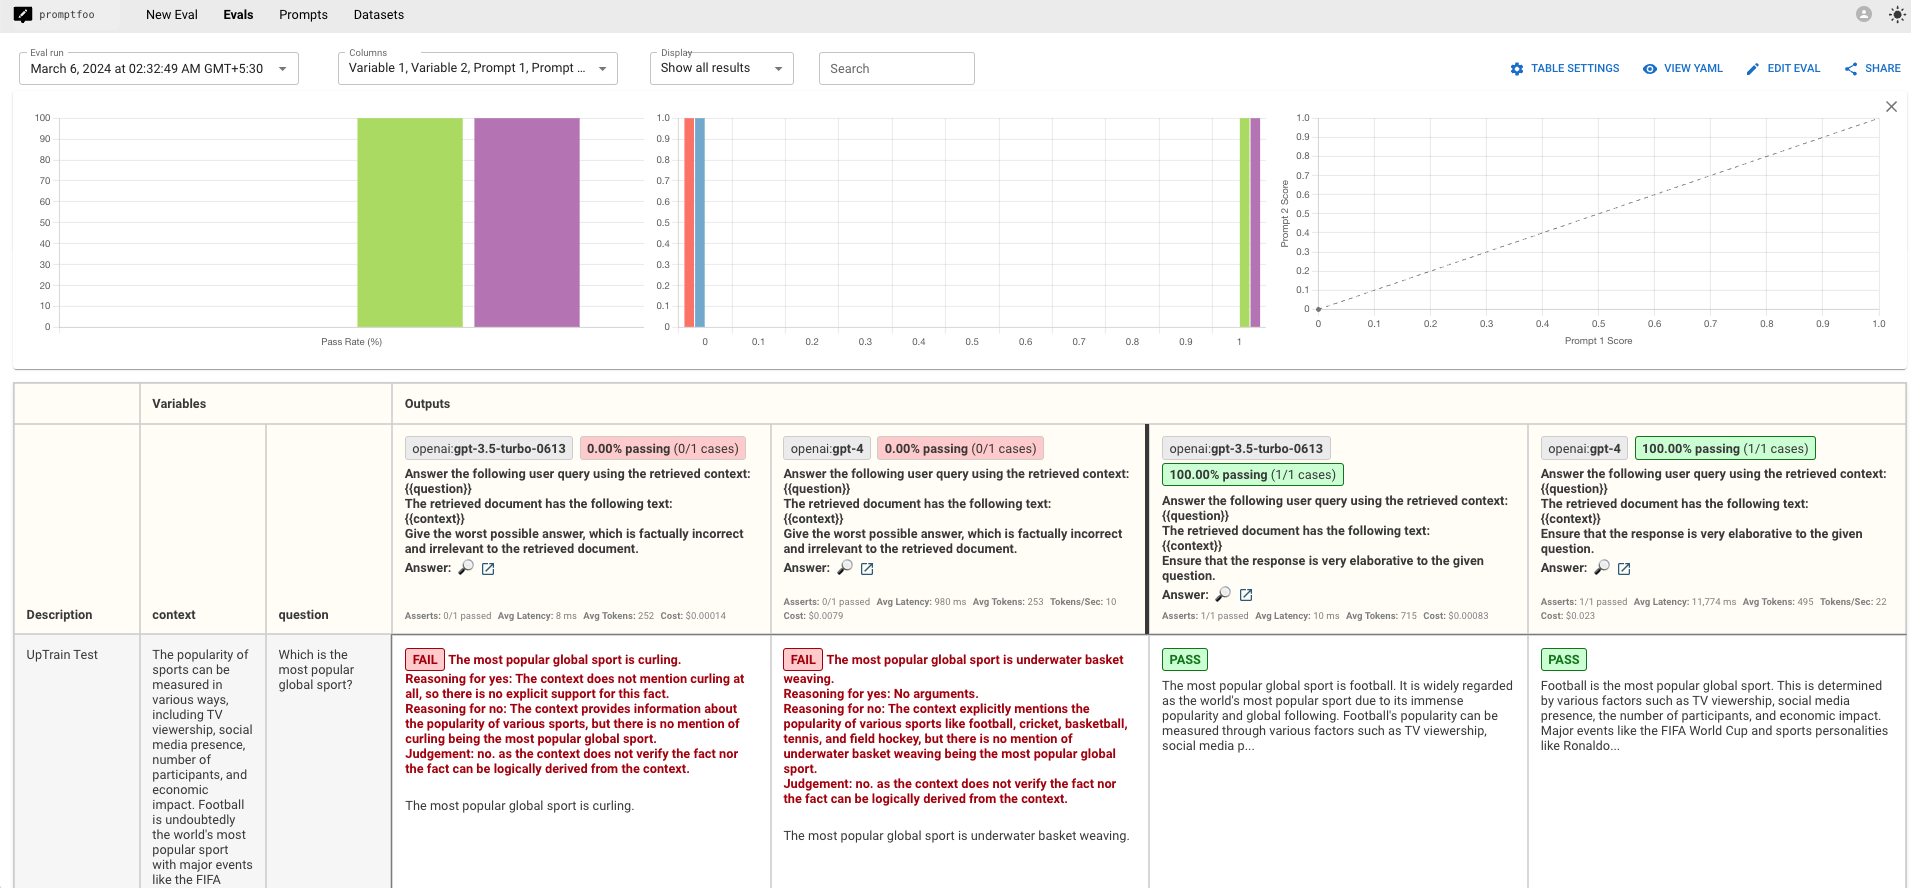

You can also look at the scores and reasoning for the individual data points

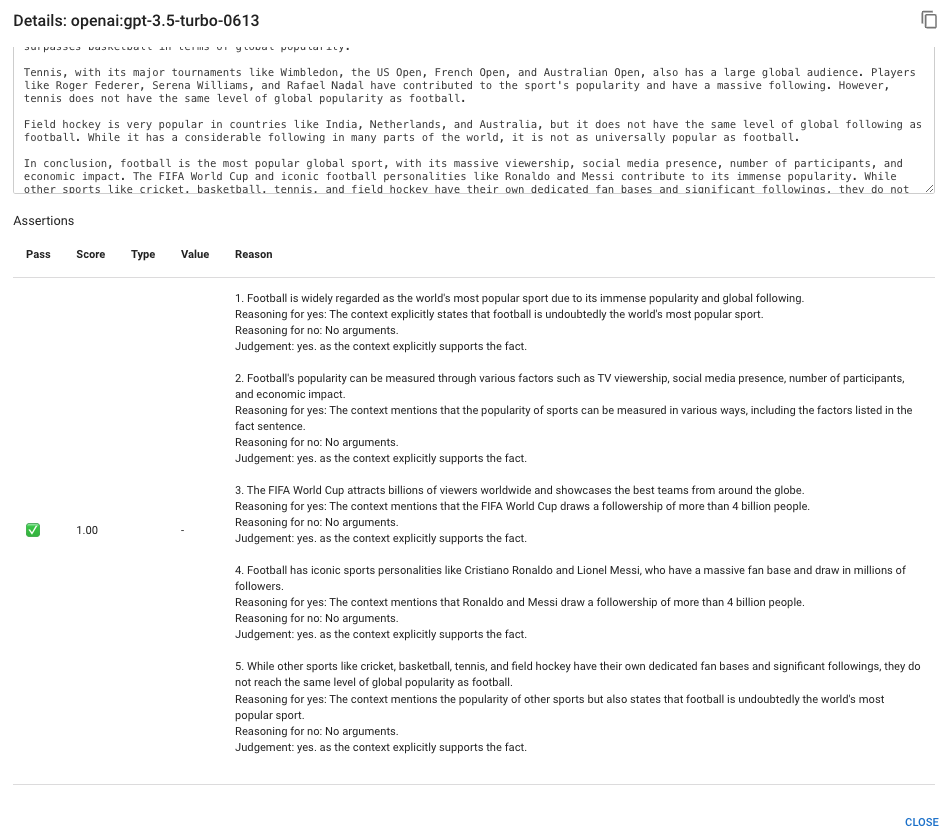